# Abstract

**Objective:** To demonstrate the construction and use of a variational auto-encoder

**Method:** TBD

Finally, in the appendix, we provide a simple breakdown of the theory behind VAEs, and how they can be used.

**Observations & Results:**  Keeping inputs standardised to `-1..1` is vital. Max-pooling is no longer necessary it seems. If you get NaNs in the loss, see if it's instanteous or not. If not, it may be an explosion: check Lambdas that, e.g. use `K.exp()`. 

**Conclusions:**

**Futher Work:** Maths of convolution and transpose-convolution layers. LeCun paper

Consider convolution-followed-by-ReLU versus convolution-followed-by-maxpool

# Configuration

In [1]:
import pathlib

CHECKPOINT_DIR = pathlib.Path.cwd()  / 'checkpoints'

if not CHECKPOINT_DIR.exists():
  CHECKPOINT_DIR.mkdir()

# Simple AutoEncoder

This is a basic auto-encoder with no


## Convenience code for Creation

The book rapidly begins using magic classes to help with its model construction. We do something analoguous, but nicer ;-)

In [4]:
from typing import NamedTuple, List, Union, Tuple, Optional

import numpy as np
import sys
import math

import tensorflow as tf

from tensorflow.keras.layers import Flatten, Dense, Input, Conv2D, Conv2DTranspose, \
  Activation, LeakyReLU, Dropout, BatchNormalization, Reshape, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from tensorflow.keras import backend as K  # tensor operations

In [5]:
class CLayerGroup(NamedTuple):
  filter_count: int = 32
  kernel_size: int = 3
  stride_size: int = 1
  padding: str = 'same'

  activation: str = 'leakyrelu'
  batch_norm_enabled: bool = False 
  dropout: Optional[float] = None


  def make_layer(self, name: Optional[str] = None) -> Conv2D:
    return Conv2D(
        filters=self.filter_count,
        kernel_size = (self.kernel_size, self.kernel_size),
        strides=self.stride_size,
        padding=self.padding,
        name=name
    )

  def make_activation(self, name: Optional[str] = None) -> Union[LeakyReLU, Activation]:
    if self.activation == 'leakyrelu':
      return LeakyReLU(name=name)
    else:
      return Activation(self.activation, name=name)

  def make_transpose_layer(self, name:str = None) -> Conv2D:
    return Conv2DTranspose(
        filters=self.filter_count,
        kernel_size = (self.kernel_size, self.kernel_size),
        strides=self.stride_size,
        padding=self.padding,
        name=name
    )

In [6]:
def _tidy_name_prefix(name_prefix: Optional[str]) -> str:
  """
  Converts None to the empty string, and strips leading/trailing
  whitespace. If the the name-prefix is not none/the empty string,
  ensure that it ends in an underscore by adding one if missing.
  """
  if name_prefix is None:
    return ''
  name_prefix = name_prefix.strip()
  if len(name_prefix) == 0:
    return ''
  if name_prefix[-1] == '_':
    return name_prefix
  else:
    return name_prefix + '_'

In [7]:
def _make_encoder(input_tensor: Input, 
                  encoders: List[CLayerGroup],
                  z_dim: int,
                  name_prefix: str) -> Tuple[Model, "KerasTensor", Tuple[int, ...]]:
  """
  Creates an encoder according to the given specification. Returns the 
  encoder model, the (placeholder) tensor representing the output of the
  encoder, and the shape immediately before flattenng and projecting
  """
  _p = name_prefix

  x = input_tensor
  for e_idx, encoder in enumerate(encoders):
    conv_layer = encoder.make_layer(f'{_p}enc_conv_{e_idx}')
    x = conv_layer(x)

    if encoder.batch_norm_enabled:
      x = BatchNormalization(name=f'{_p}enc_bnorm_{e_idx}')(x)
    
    act = encoder.make_activation(f'{_p}enc_act_{e_idx}')
    x = act(x)

    if encoder.dropout is not None:
      x = Dropout(rate=encoder.dropout, name=f'{_p}enc_dropout_{e_idx}')(x)

  shape_before_flatten = K.int_shape(x)[1:]  # First dimension is dataset size
  x = Flatten(name=f'{_p}enc_flatten')(x)

  output_tensor = Dense(units=z_dim, name=f'{_p}enc_output')(x)
  # NOTE: That the output is unconstrained, can be any real number
  #       We rely on training regularization I guess to deal with this

  encoder_model = Model(input_tensor, output_tensor)
  return encoder_model, output_tensor, shape_before_flatten

In [8]:
def _make_decoder(input_tensor: Input,
                  decoders: List[CLayerGroup],
                  unflatten_shape: Tuple[int, ...],
                  name_prefix: str) -> Model:
  _p = name_prefix

  # Explode from z_dim to original shape at end of convolutional chain
  x = Dense(units=np.prod(unflatten_shape), name=f'{_p}dec_expand')(input_tensor)
  x = Reshape(unflatten_shape, name=f'{_p}dec_unflat')(x)  # Note how this skips first dimension: dataset-size

  # Apply all but the last decoders (see below)
  for d_idx, decoder in enumerate(decoders[:-1]):
    conv_t_layer = decoder.make_transpose_layer(f'{_p}dec_conv_{d_idx}')
    x = conv_t_layer(x)

    if decoder.batch_norm_enabled:
      x = BatchNormalization(name=f'{_p}dec_bnorm_{d_idx}')(x)

    act = decoder.make_activation(name=f'{_p}dec_act_{d_idx}')
    x = act(x)

    if decoder.dropout is not None:
      x = Dropout(rate=decoder.dropout, name=f'{_p}dec_dropout_{d_idx}')(x)

  # The last decoder gets special attention as it should produce exactly the
  # input, so we have to use sigmoid, and can't dropout
  decoder = decoders[-1]
  assert decoder.dropout is None, "Final decoder can't have dropout"
  assert not decoder.batch_norm_enabled, "Final decoder can't have batch norm enabled"
  assert decoder.activation == 'sigmoid', "Final decoder can only use sigmoid activation"

  conv_t_layer = decoder.make_transpose_layer(f'{_p}dec_final_decode')
  x = conv_t_layer(x)

  act = Activation('sigmoid', name=f'{_p}dec_sigmoid_output')
  output_tensor = act(x)

  return Model(input_tensor, output_tensor)

In [9]:
def make_autoencoder(input_shape: Tuple[int, ...], 
                     encoders: List[CLayerGroup], 
                     decoders: List[CLayerGroup],
                     z_dim: int,
                     name_prefix: Optional[str] = None) -> Model:
  name_prefix = _tidy_name_prefix(name_prefix)

  enc_input_tensor = Input(shape=input_shape, name=f'{name_prefix}encoder_input')
  encoder, enc_output_tensor, projected_shape = \
    _make_encoder(enc_input_tensor, encoders, z_dim, name_prefix)

  dec_input_tensor = Input(shape=(z_dim,), name=f'{name_prefix}decoder_input')
  decoder = _make_decoder(dec_input_tensor, decoders, projected_shape, name_prefix)

  dec_output_tensor = decoder(enc_output_tensor) # Applying a model to a placeholder
                                                 # tensor to get an output tensor.
  ae = Model(enc_input_tensor, dec_output_tensor)

  return ae, encoder, decoder

In [10]:
encoder_layers = [
    CLayerGroup(filter_count=32, kernel_size=3, stride_size=1),
    CLayerGroup(filter_count=64, kernel_size=3, stride_size=2),
    CLayerGroup(filter_count=64, kernel_size=3, stride_size=2),
    CLayerGroup(filter_count=64, kernel_size=3, stride_size=1)
]
decoder_layers = [
    CLayerGroup(filter_count=64, kernel_size=3, stride_size=1),
    CLayerGroup(filter_count=64, kernel_size=3, stride_size=2),
    CLayerGroup(filter_count=32, kernel_size=3, stride_size=2),
    CLayerGroup(filter_count=1, kernel_size=3, stride_size=1, 
                batch_norm_enabled=False, dropout=None, activation='sigmoid')
]

ae, enc, dec = make_autoencoder(input_shape=(28, 28, 1),
                      encoders=encoder_layers,
                      decoders=decoder_layers,
                      z_dim=2,
                      name_prefix='ae')


In [11]:
enc.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
ae_encoder_input (InputLayer [(None, 28, 28, 1)]       0         
_________________________________________________________________
ae_enc_conv_0 (Conv2D)       (None, 28, 28, 32)        320       
_________________________________________________________________
ae_enc_act_0 (LeakyReLU)     (None, 28, 28, 32)        0         
_________________________________________________________________
ae_enc_conv_1 (Conv2D)       (None, 14, 14, 64)        18496     
_________________________________________________________________
ae_enc_act_1 (LeakyReLU)     (None, 14, 14, 64)        0         
_________________________________________________________________
ae_enc_conv_2 (Conv2D)       (None, 7, 7, 64)          36928     
_________________________________________________________________
ae_enc_act_2 (LeakyReLU)     (None, 7, 7, 64)          0     

In [12]:
dec.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
ae_decoder_input (InputLayer [(None, 2)]               0         
_________________________________________________________________
ae_dec_expand (Dense)        (None, 3136)              9408      
_________________________________________________________________
ae_dec_unflat (Reshape)      (None, 7, 7, 64)          0         
_________________________________________________________________
ae_dec_conv_0 (Conv2DTranspo (None, 7, 7, 64)          36928     
_________________________________________________________________
ae_dec_act_0 (LeakyReLU)     (None, 7, 7, 64)          0         
_________________________________________________________________
ae_dec_conv_1 (Conv2DTranspo (None, 14, 14, 64)        36928     
_________________________________________________________________
ae_dec_act_1 (LeakyReLU)     (None, 14, 14, 64)        0   

In [13]:
ae.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
ae_encoder_input (InputLayer [(None, 28, 28, 1)]       0         
_________________________________________________________________
ae_enc_conv_0 (Conv2D)       (None, 28, 28, 32)        320       
_________________________________________________________________
ae_enc_act_0 (LeakyReLU)     (None, 28, 28, 32)        0         
_________________________________________________________________
ae_enc_conv_1 (Conv2D)       (None, 14, 14, 64)        18496     
_________________________________________________________________
ae_enc_act_1 (LeakyReLU)     (None, 14, 14, 64)        0         
_________________________________________________________________
ae_enc_conv_2 (Conv2D)       (None, 7, 7, 64)          36928     
_________________________________________________________________
ae_enc_act_2 (LeakyReLU)     (None, 7, 7, 64)          0   

## Putting it into Practice

Note that in this case we're autoencoding black and white images, so there are two variants

 1. Binary cross-entropy
 2. Mean-squared error

Book says that "binary cross-entropy tends to put heavier penalities on predictions at the extremes that are badly wrong, so it tends to push pixel predictions to the middle of the range, leading to less vibrant images. For this reason, I generally  prefer to use RMSE"



In [14]:
optimizer = Adam(learning_rate=0.0005)

def rms_loss(y_true: "KerasTensor", y_pred: "KerasTensor"):
  # Equivalent to a Gaussian likelihood with unit variance
  return K.mean(K.square(y_true - y_pred), axis=[1, 2])

ae.compile(optimizer=optimizer,
           loss=rms_loss,
           metrics=['accuracy'])

In [16]:
import tensorflow.keras.utils as kutils
from tensorflow.keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype(np.float32) / 255
x_test  = x_test.astype(np.float32) / 255

# y_train = kutils.to_categorical(y_train)
# y_test = kutils.to_categorical(y_test)

11493376/11490434 [==============================] - 1s 0us/step


###  Training at scale

A few things that are obvious

 1. Once you use convolution, training times become _very_ slow. Use a TPU or GPU.
 2. With SGD, there's not guarantee that the loss / accuracy will continuously improve. It may get worse. So you will probably want to save regular checkpoints so you can fetch the best one.
 3. Only a similar vein, you will need to pay attention to your training schedule, so you don't get stuck hopping around the edge of a local minimum

In training (use a GPU for this) it becomes very clear that the accuracy falls and lowers (SGD consequence)

In [17]:
# A callback to regulate convergence

from tensorflow.keras.callbacks import Callback, LearningRateScheduler, ModelCheckpoint

def step_decay_schedule(initial_learning_rate: float,
                        decay_factor: float = 0.5,
                        step_size: int = 1) -> LearningRateScheduler:
  """
  Create a learning-rate schedule that amends the learning-rate
  every step_size epochs.

  t = epoch // step_size
  lr[epoch] = lr[epoch-1] * decay^t 

  """
  def learning_rate_at_epoch(epoch: int) -> float:
    new_lr = initial_learning_rate * (decay_Factor ** (epoch // step_size))

  return LearningRateScheduler(schedule=learning_rate_at_epoch)
  

In [18]:
initial_learning_rate = 0.0005
decay_factor = 1
step_size = 1

learning_rate_callback = LearningRateScheduler(
    schedule=lambda epoch: initial_learning_rate * (decay_factor **  (epoch // step_size))
)

ae_checkpoint_file = CHECKPOINT_DIR / 'simple-ae'
weight_save_check_point_callback = ModelCheckpoint(filepath=ae_checkpoint_file,
                                                   save_weights_only=True,
                                                   save_best_only=True,
                                                   monitor='val_accuracy',
                                                   mode='max',
                                                   verbose=1)

In [19]:
ae.fit(x_train, x_train,
       validation_data=(x_test, x_test),
       batch_size=256,
       epochs=4,
       initial_epoch=0,
       shuffle=True,
       callbacks=[
                  learning_rate_callback,
                  weight_save_check_point_callback
       ]
)

Epoch 1/4
235/235 [==============================] - 28s 36ms/step - loss: 0.1216 - accuracy: 0.7896 - val_loss: 0.0561 - val_accuracy: 0.7944

Epoch 00001: val_accuracy improved from -inf to 0.79435, saving model to C:\Users\bryan\Google Drive\Colab Notebooks\checkpoints\simple-ae
Epoch 2/4
235/235 [==============================] - 7s 31ms/step - loss: 0.0554 - accuracy: 0.7960 - val_loss: 0.0531 - val_accuracy: 0.7958

Epoch 00002: val_accuracy improved from 0.79435 to 0.79575, saving model to C:\Users\bryan\Google Drive\Colab Notebooks\checkpoints\simple-ae
Epoch 3/4
235/235 [==============================] - 7s 31ms/step - loss: 0.0526 - accuracy: 0.7971 - val_loss: 0.0509 - val_accuracy: 0.7961

Epoch 00003: val_accuracy improved from 0.79575 to 0.79609, saving model to C:\Users\bryan\Google Drive\Colab Notebooks\checkpoints\simple-ae
Epoch 4/4
235/235 [==============================] - 7s 31ms/step - loss: 0.0504 - accuracy: 0.7964 - val_loss: 0.0491 - val_accuracy: 0.7970

Epoc

In [20]:
ae.load_weights(ae_checkpoint_file) # Set ourselves to the best version...

In [21]:
list(CHECKPOINT_DIR.glob('**/*'))

[WindowsPath('C:/Users/bryan/Google Drive/Colab Notebooks/checkpoints/checkpoint'),
 WindowsPath('C:/Users/bryan/Google Drive/Colab Notebooks/checkpoints/simple-ae.data-00000-of-00001'),
 WindowsPath('C:/Users/bryan/Google Drive/Colab Notebooks/checkpoints/simple-ae.index')]

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt


<AxesSubplot:>

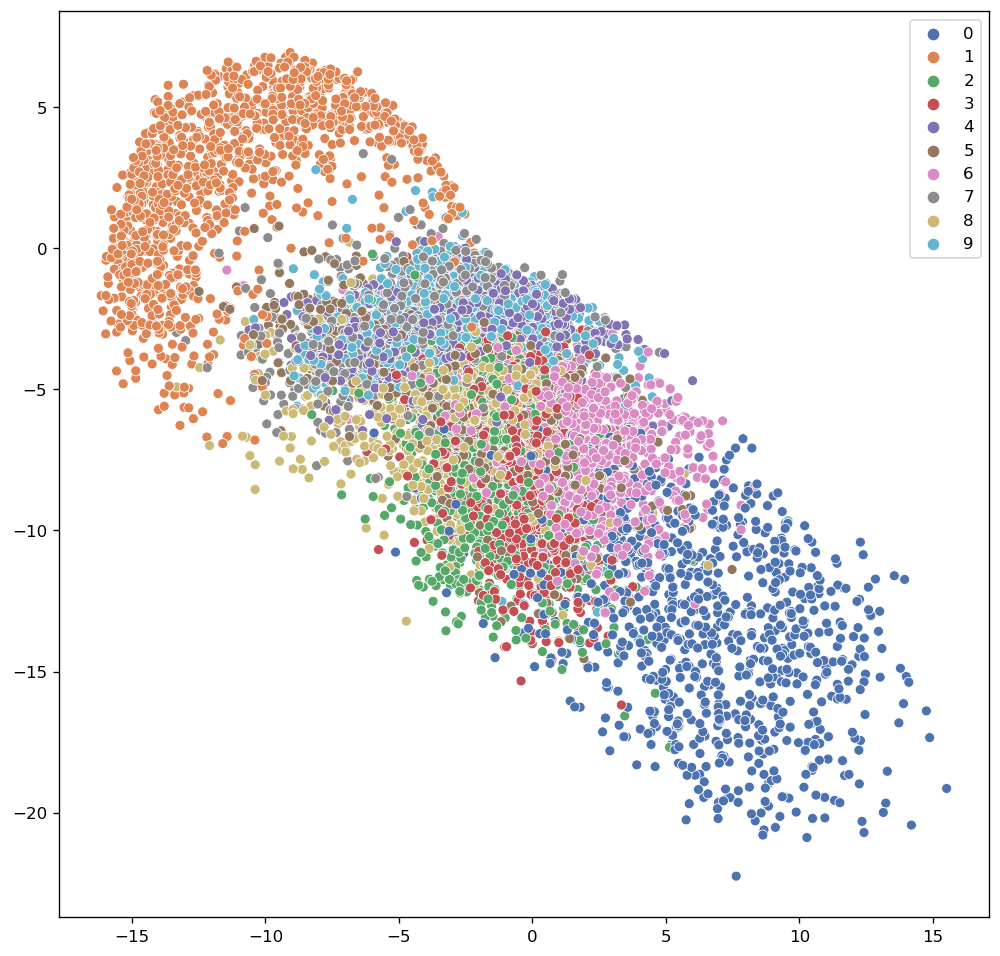

In [23]:
y_pred = enc.predict(x_test)

fig, ax = plt.subplots(figsize=(10, 10), dpi=120)
sns.scatterplot(x=y_pred[:,0], y=y_pred[:,1], hue=y_test, palette="deep", ax=ax)

In [24]:
y_pred

array([[ -4.389397  ,  -2.677417  ],
       [  0.10818581,  -8.112182  ],
       [-12.75748   ,   2.3479748 ],
       ...,
       [ -5.7187834 ,  -3.3614206 ],
       [ -5.5625668 ,  -4.3934193 ],
       [  4.2169437 , -10.6514015 ]], dtype=float32)

# Variational Auto-Encoder

The plot above is not symmetric about the points, or bounded, which makes it hard to generate samples. Also we're perhaps not using all the sample space equally.

The solution is the variational auto-encoder. The encoder learns the means and variances of several Gaussians (but no mixing proportions).

Then instead of feeding the encoded value directly to the decoder when training, we instead _sample_ from the encoded distribution, and then ask the decoder to use that to decode back to the _same_ input.

We use a `Lambda` layer to do this, which simply wraps a function into a layer. This is a convenience class, Keras devs strongly recommend subclassing `Layer` instead.

In [28]:
def _make_vae_encoder(input_tensor: Input, 
                      encoders: List[CLayerGroup],
                      z_dim: int,
                      name_prefix: str) -> Tuple[Model, 
                                                 Tuple["KerasTensor", "KerasTensor"], 
                                                 Tuple[int, ...]]:
  """
  Creates an encoder according to the given specification. Returns the 
  encoder model, the (placeholder) tensor representing the output of the
  encoder, and the shape immediately before flattenng and projecting

  Exactly the same as _make_encoder except we also predict the log-variance
  (log to enforce positivity constraint), and then add scaled-Gaussian noise
  to the prediction...
  """
  _p = name_prefix

  x = input_tensor
  for e_idx, encoder in enumerate(encoders):
    conv_layer = encoder.make_layer(f'{_p}venc_conv_{e_idx}')
    x = conv_layer(x)
    
    if encoder.batch_norm_enabled:
      x = BatchNormalization(name=f'{_p}venc_bnorm_{e_idx}')(x)
    
    act = encoder.make_activation(name=f'{_p}venc_act_{e_idx}')
    x = act(x)

    if encoder.dropout is not None:
      x = Dropout(rate=encoder.dropout, name=f'{_p}venc_dropout_{e_idx}')(x)

  shape_before_flatten = K.int_shape(x)[1:]  # First dimension is dataset size
  x = Flatten(name=f'{_p}venc_flatten')(x)

  # Up till now it's been the same as _make_encoder(). The difference is here.
  # Instead of learning a low-dim representation, we learn a distribution from
  # which we sample a low-dim representation. This is all about how tight the
  # variance (diagonal) is.
  # By outputing a sample, instead of the mean, we encode a preference for
  # all points in a region to map to the same number, e.g. 1.9, 2.1 == 2.0, 2.0
  param_mean = Dense(units=z_dim, name=f'{_p}venc_output_mean')(x)
  param_log_var = Dense(units=z_dim, 
                        activation='tanh',  # Needed for when we don't have KL regularization
                        name=f'{_p}venc_output_log_var')(x)
  
  encoder_parameter_model = Model(input_tensor, (param_mean, param_log_var))

  def sample_from_encoded_space(args: Tuple["KerasTensor", ...]) -> "KerasTensor":
    m, l = args
    # How to sample a vector from a Gaussian with diagonal variance using only
    # a univariate distribution...
    #
    # Note that without internal (via activation-fnc) or external (via KL 
    # regularizer in loss), the log-var may explode and lead to NaN losses
    scale = K.random_normal(shape=K.shape(m), mean=0.0, stddev=1.0)
    sample = m + K.exp(l / 2) * scale
    return sample

  encoder_output_tensor = Lambda(
      function=sample_from_encoded_space,
      name=f'{_p}venc_sample'
  )([param_mean, param_log_var])

  # encoder_model = Model(input_tensor, encoder_output_tensor)
  encoder_model = Model(input_tensor, encoder_output_tensor)

  # return encoder_model, encoder_output_tensor, shape_before_flatten, (param_mean, param_log_var)
  return encoder_model, encoder_output_tensor, shape_before_flatten, (param_mean, param_log_var)

# Relaxing the regularization in an Appropriate Way

The KL divergence between two Normal distributions $p_1 = N(\mu_1,\Sigma_1)$ and $p_2 = N(\mu_2, \Sigma_2)$ over dimension $D$ is [given by](https://stats.stackexchange.com/questions/60680/kl-divergence-between-two-multivariate-gaussians)

$$
\text{KL}[ p_1 || p_2 ] =
\frac{1}{2}\left[
  \ln \frac{|\Sigma_2|}{|\Sigma_1|} 
  - D 
  + \text{tr}(\Sigma_2^{-1} \Sigma_1)
  + (\mu_2 - \mu_1)^\top \Sigma_2^{-1}(\mu_2 - \mu_1)
\right]
$$

In the specific case of the paper, the distance from the posterior $q = N(\boldsymbol{\mu}, \text{diag}(\boldsymbol{\sigma}^2))$ to the prior $p = N(\boldsymbol{0}, I_D)$:

$$
- \text{KL}[ q || p ] =
\frac{1}{2} \sum_{d=1}^D \left(
  1  +  \ln(\sigma_d^2) - \mu_d^2 - \sigma_d^2
\right)
$$

Doing some sums, we end up with the solution for when our prior is $p = N(\boldsymbol{0}, \alpha^2 I)$ we end up with the following adjusted regularization lost

$$
- \text{KL}[ q || p ] =
\frac{1}{2} \sum_{d=1}^D \left(
  1  +  \ln\left(\frac{\sigma_d^2}{\alpha^2}\right) - \frac{\mu_d^2}{\alpha^2} - \frac{\sigma_d^2}{\alpha^2}
\right)
$$

This still doesn't really help though, we still end up with all individual digits having the same posterior distribution:  we're not fully utilising the space.

Multipying _this_ formula by some scaling factor is just equivalent to putting a huge variance on the likelihood. 

In [29]:
def make_vae_autoencoder(input_shape: Tuple[int, ...], 
                         encoders: List[CLayerGroup], 
                         decoders: List[CLayerGroup],
                         z_dim: int,
                         z_var_prior: float = 1,
                         likely_var = 1,
                         name_prefix: Optional[str] = None) -> Model:
  log_z_var_prior = math.log(z_var_prior)
  name_prefix = _tidy_name_prefix(name_prefix)

  enc_input_tensor = Input(shape=input_shape, name=f'{name_prefix}encoder_input')
  encoder, enc_output_tensor, projected_shape, (mu, log_var) = \
    _make_vae_encoder(enc_input_tensor, encoders, z_dim, name_prefix)

  dec_input_tensor = Input(shape=(z_dim,), name=f'{name_prefix}decoder_input')
  decoder = _make_decoder(dec_input_tensor, decoders, projected_shape, name_prefix)

  dec_output_tensor = decoder(enc_output_tensor) # Applying a model to a placeholder
                                                 # tensor to get an output tensor.
  vae = Model(enc_input_tensor, dec_output_tensor)

  # Regularization loss is best handled via add_loss functions. These will be
  # added to the overall loss in training...
  kl_loss = (1/likely_var) * -0.5 * tf.reduce_mean(log_var - log_z_var_prior  - K.square(mu/z_var_prior) - K.exp(log_var)/z_var_prior + 1)
  vae.add_loss(kl_loss)

  return vae, encoder, decoder, mu, log_var

In [32]:
import tensorflow.keras.backend as kbackend
kbackend.clear_session()

vae, venc, dec, mu, log_var = make_vae_autoencoder(input_shape=(28, 28, 1),
                                                   encoders=encoder_layers,
                                                   decoders=decoder_layers,
                                                   z_dim=2,
                                                   z_var_prior=2**2,
                                                   likely_var=1000,
                                                   name_prefix='vae')

In [34]:
!conda install pydot

^C


In [35]:
from tensorflow.keras.utils import plot_model
plot_model(venc, show_shapes = True, show_layer_names = True)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [37]:
from tensorflow.keras.losses import MeanSquaredError

loss_fn = MeanSquaredError()

opt = Adam(learning_rate=0.0005)


vae.compile(
    optimizer=opt,
    loss=loss_fn,
    metrics=['mse', 'accuracy']
)

In [38]:
# vae.fit(x_train, x_train,
#         batch_size=32,
#         epochs=10,
#         shuffle=True
# )

vae.fit(x_train, x_train,
        validation_data=(x_test, x_test),
        batch_size=32,
        epochs=10,
        initial_epoch=0,
        shuffle=True,
        callbacks=[
                  learning_rate_callback,
                  weight_save_check_point_callback
       ]
)

Epoch 1/10
1875/1875 [==============================] - 36s 18ms/step - loss: 0.0713 - mse: 0.0700 - accuracy: 0.7924 - val_loss: 0.0506 - val_mse: 0.0492 - val_accuracy: 0.7935

Epoch 00001: val_accuracy did not improve from 0.79705
Epoch 2/10
1875/1875 [==============================] - 33s 18ms/step - loss: 0.0500 - mse: 0.0485 - accuracy: 0.7965 - val_loss: 0.0486 - val_mse: 0.0470 - val_accuracy: 0.7968

Epoch 00002: val_accuracy did not improve from 0.79705
Epoch 3/10
1875/1875 [==============================] - 34s 18ms/step - loss: 0.0481 - mse: 0.0465 - accuracy: 0.7971 - val_loss: 0.0471 - val_mse: 0.0454 - val_accuracy: 0.7973

Epoch 00003: val_accuracy improved from 0.79705 to 0.79732, saving model to C:\Users\bryan\Google Drive\Colab Notebooks\checkpoints\simple-ae
Epoch 4/10
1875/1875 [==============================] - 32s 17ms/step - loss: 0.0471 - mse: 0.0454 - accuracy: 0.7976 - val_loss: 0.0470 - val_mse: 0.0453 - val_accuracy: 0.7985

Epoch 00004: val_accuracy improv

<AxesSubplot:>

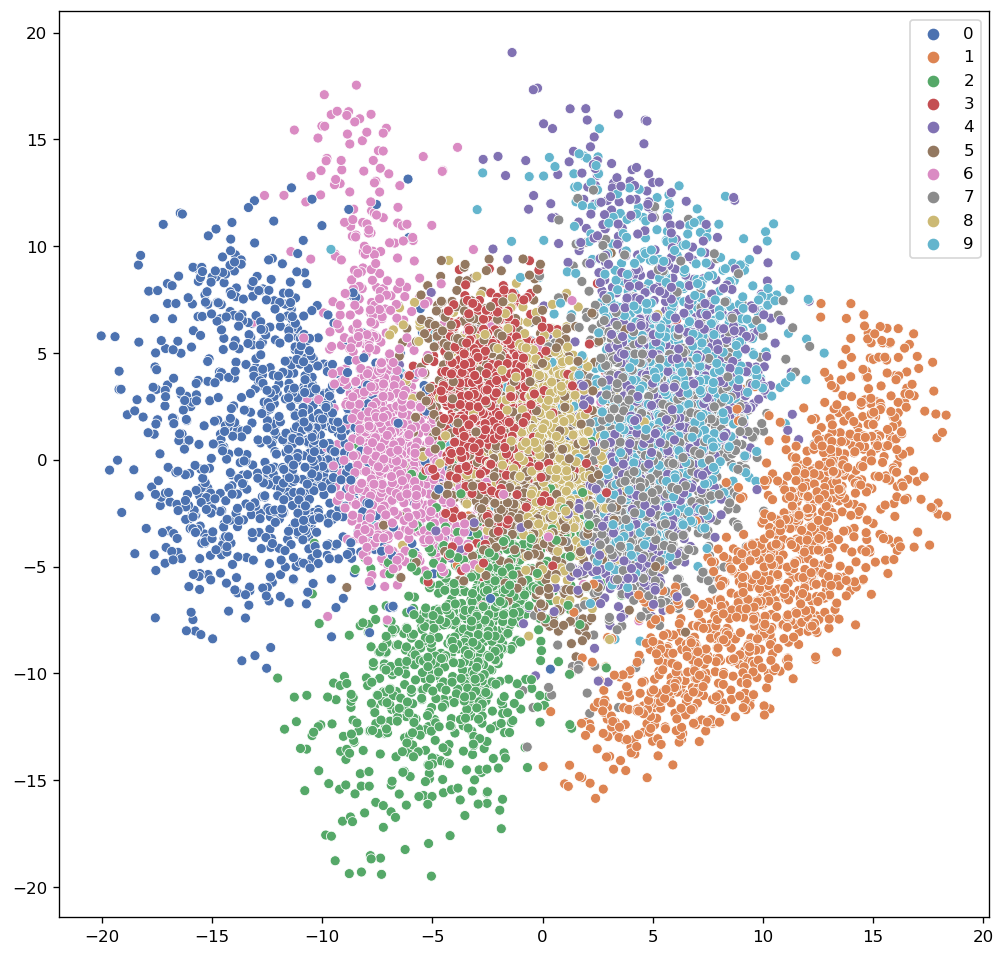

In [39]:
y_pred = venc.predict(x_test)

fig, ax = plt.subplots(figsize=(10, 10), dpi=120)
sns.scatterplot(x=y_pred[:,0], y=y_pred[:,1], hue=y_test, palette="deep", ax=ax)

In [40]:
rs  = list(range(6, -6, -1))
cs  = list(range(-6, 6, 1))

to_plot = np.zeros((len(rs) * 28, len(cs) * 28))

for row, r in enumerate(rs):
  for col, c in enumerate(cs):
    to_plot[row * 28:row*28+28, col*28:col*28+28] = np.squeeze(dec.predict(np.array([[c, r]])))


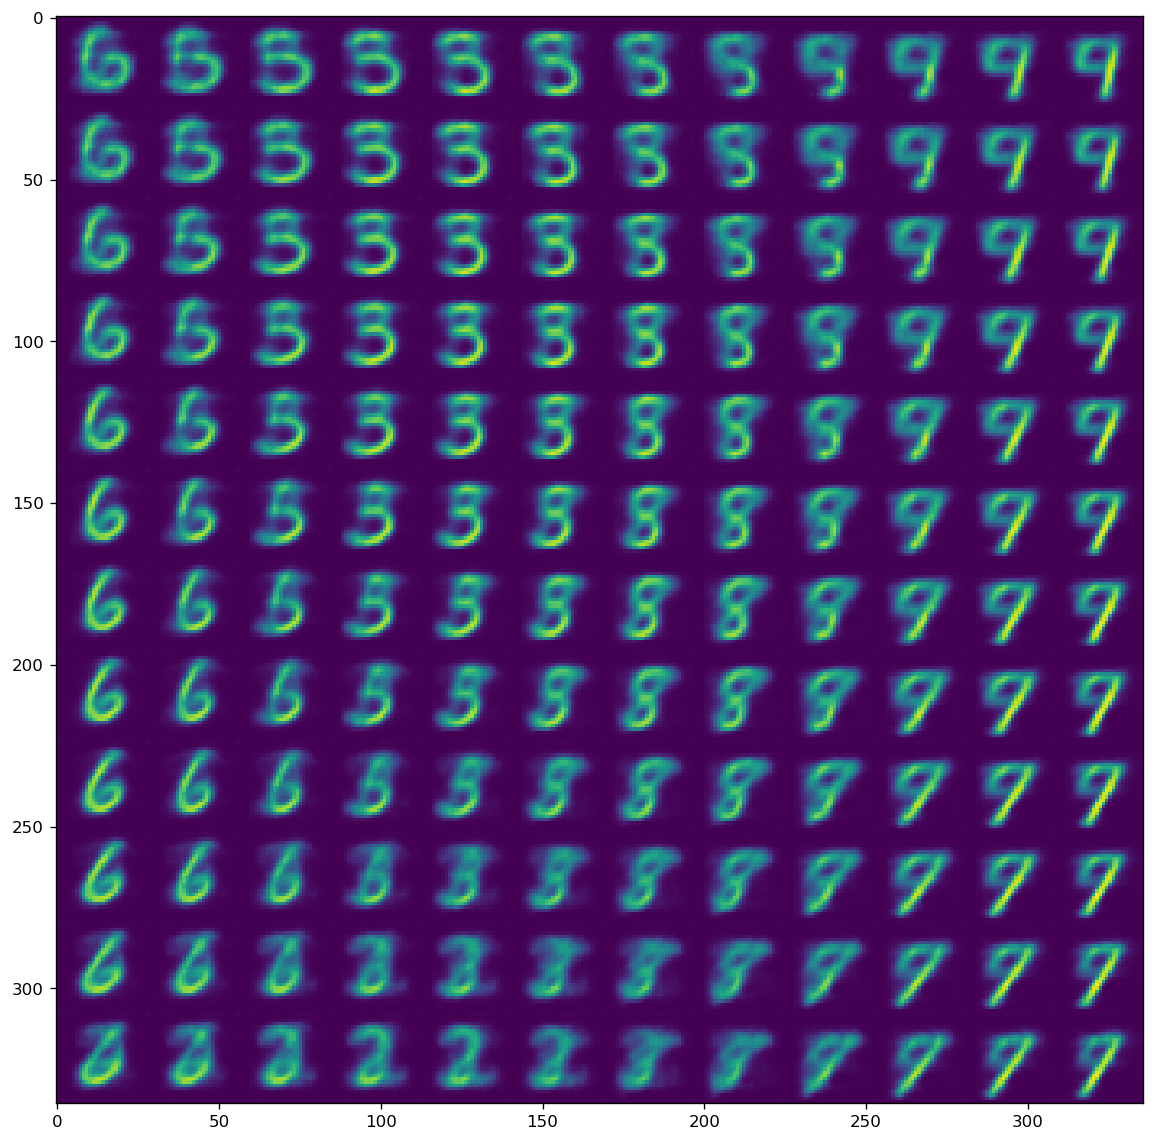

In [41]:
fig, ax = plt.subplots(figsize=(12, 12), dpi=120)
ax.imshow(to_plot)

proper way to scale is using KL Divergence: https://stats.stackexchange.com/questions/60680/kl-divergence-between-two-multivariate-gaussians

Also look at: https://keras.io/api/losses/



# Appendix

## Convolutional Transpose Layers

These revert a convolution. Strides here is also reverted: a stride of two in a convolutional layer halves an output size, in a transpose layer it doubles the size.

So if this is the input to a convolution-transose layer

    123
    456
    789

With `strides=2` it's

    00000000
    01020300
    00000000
    04050600
    00000000
    07080900
    00000000
    00000000


Hence we can e.g. convolve

    000     
    010 --> 1 pixel
    000

and gradually go across. We need an extra row of zeroes on right and bottom to regain the full image size.

> FIXME check on theory of this.... Apparently the shitty paper on convolutional arithmetic will explain




